# Music augmentation 101

Notebook hopes to provide guidance on

-  Augmenting data
-  Plotting waveforms for different effects using librosa
-  Flexibly generate your own data sets for different exerecises

In [1]:
%load_ext autoreload
%autoreload 2  # use this to reload after making changes
import warnings
from inspect import getmembers, signature, isclass
from pprint import pprint
import numpy as np
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

warnings.simplefilter('ignore') # ignore non-critical warnings
# https://www.idmt.fraunhofer.de/en/business_units/m2d/smt/guitar.html
DOWNLOAD_PATH = '/Users/BhavishDaswani/Downloads/' + 'IDMT-SMT-GUITAR_V2/dataset1/'

# Plotting .wav files

DPI and sampling rate changed from 900 and 22500 respectively 

In [2]:
import librosa 
import librosa.display


filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename, sr = 41000, duration = 10) # our default

# Hijacking code!
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        librosa.display.waveplot(np.array(f), sr=41000)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        specgram(np.array(f), Fs=41000)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()


def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25, 60), dpi=150)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(10, 1, i)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(f)) ** 2, ref=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram', x=0.5, y=0.915, fontsize=18)
    plt.show()
    
def plot_all(sound_names, raw_sounds):
    plot_waves(sound_names, raw_sounds)
    plot_specgram(sound_names, raw_sounds)
    plot_log_power_specgram(sound_names, raw_sounds)


# Don't ask me what features do, ideally we'd like to share our understanding in another pynb. 

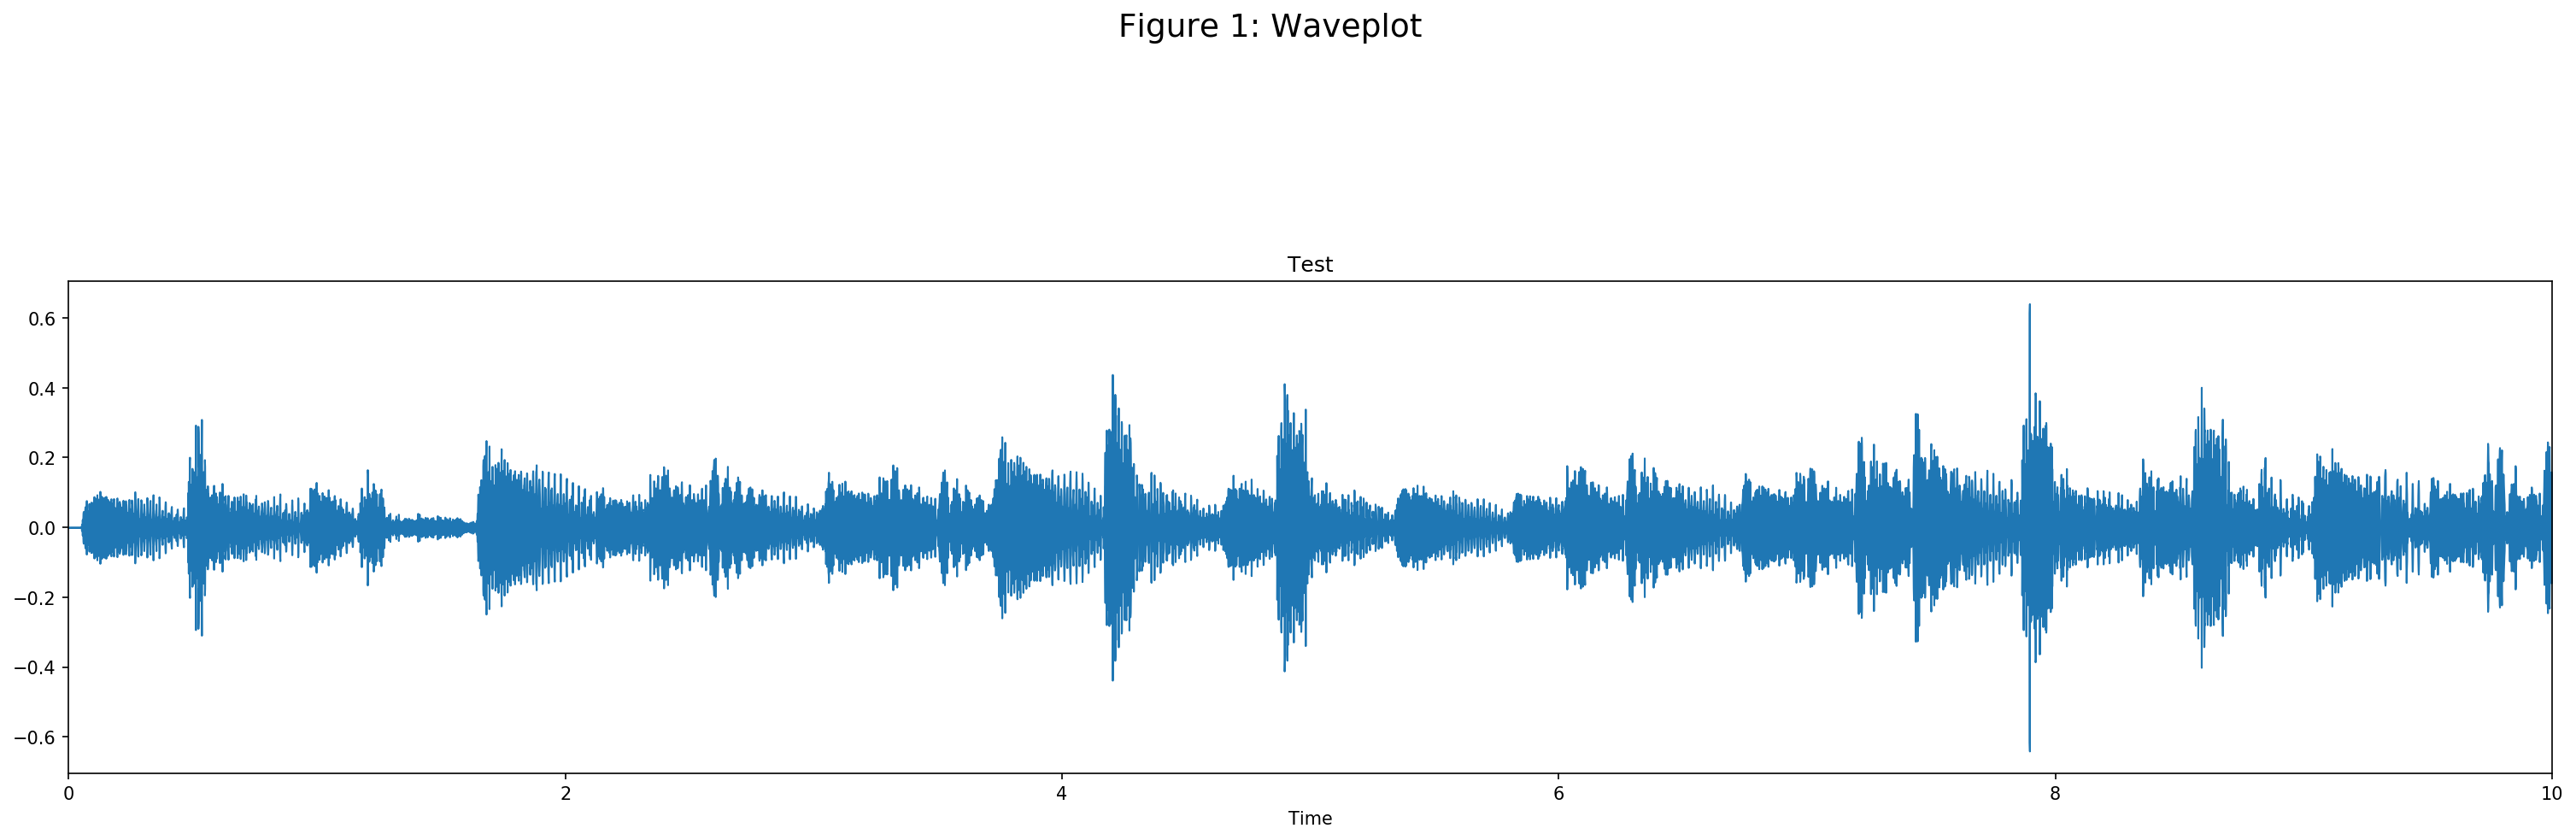

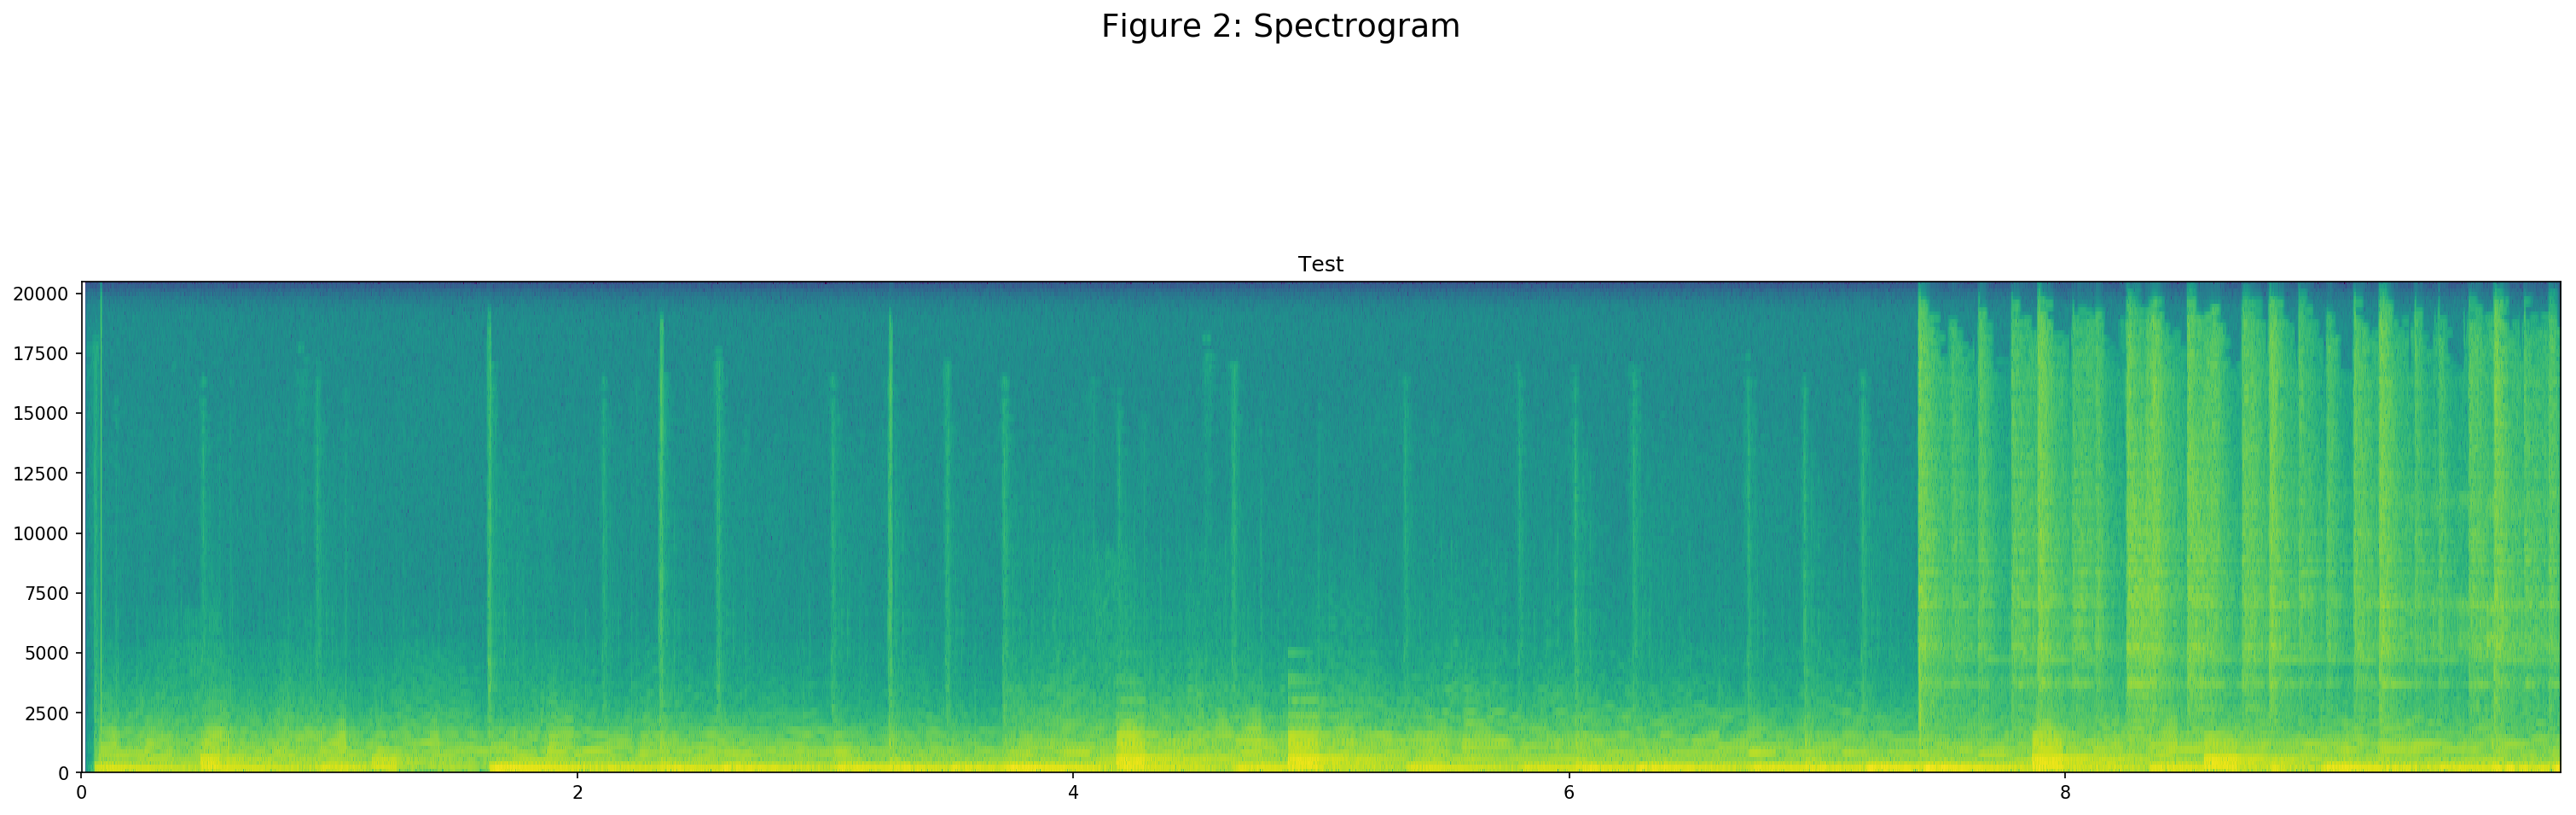

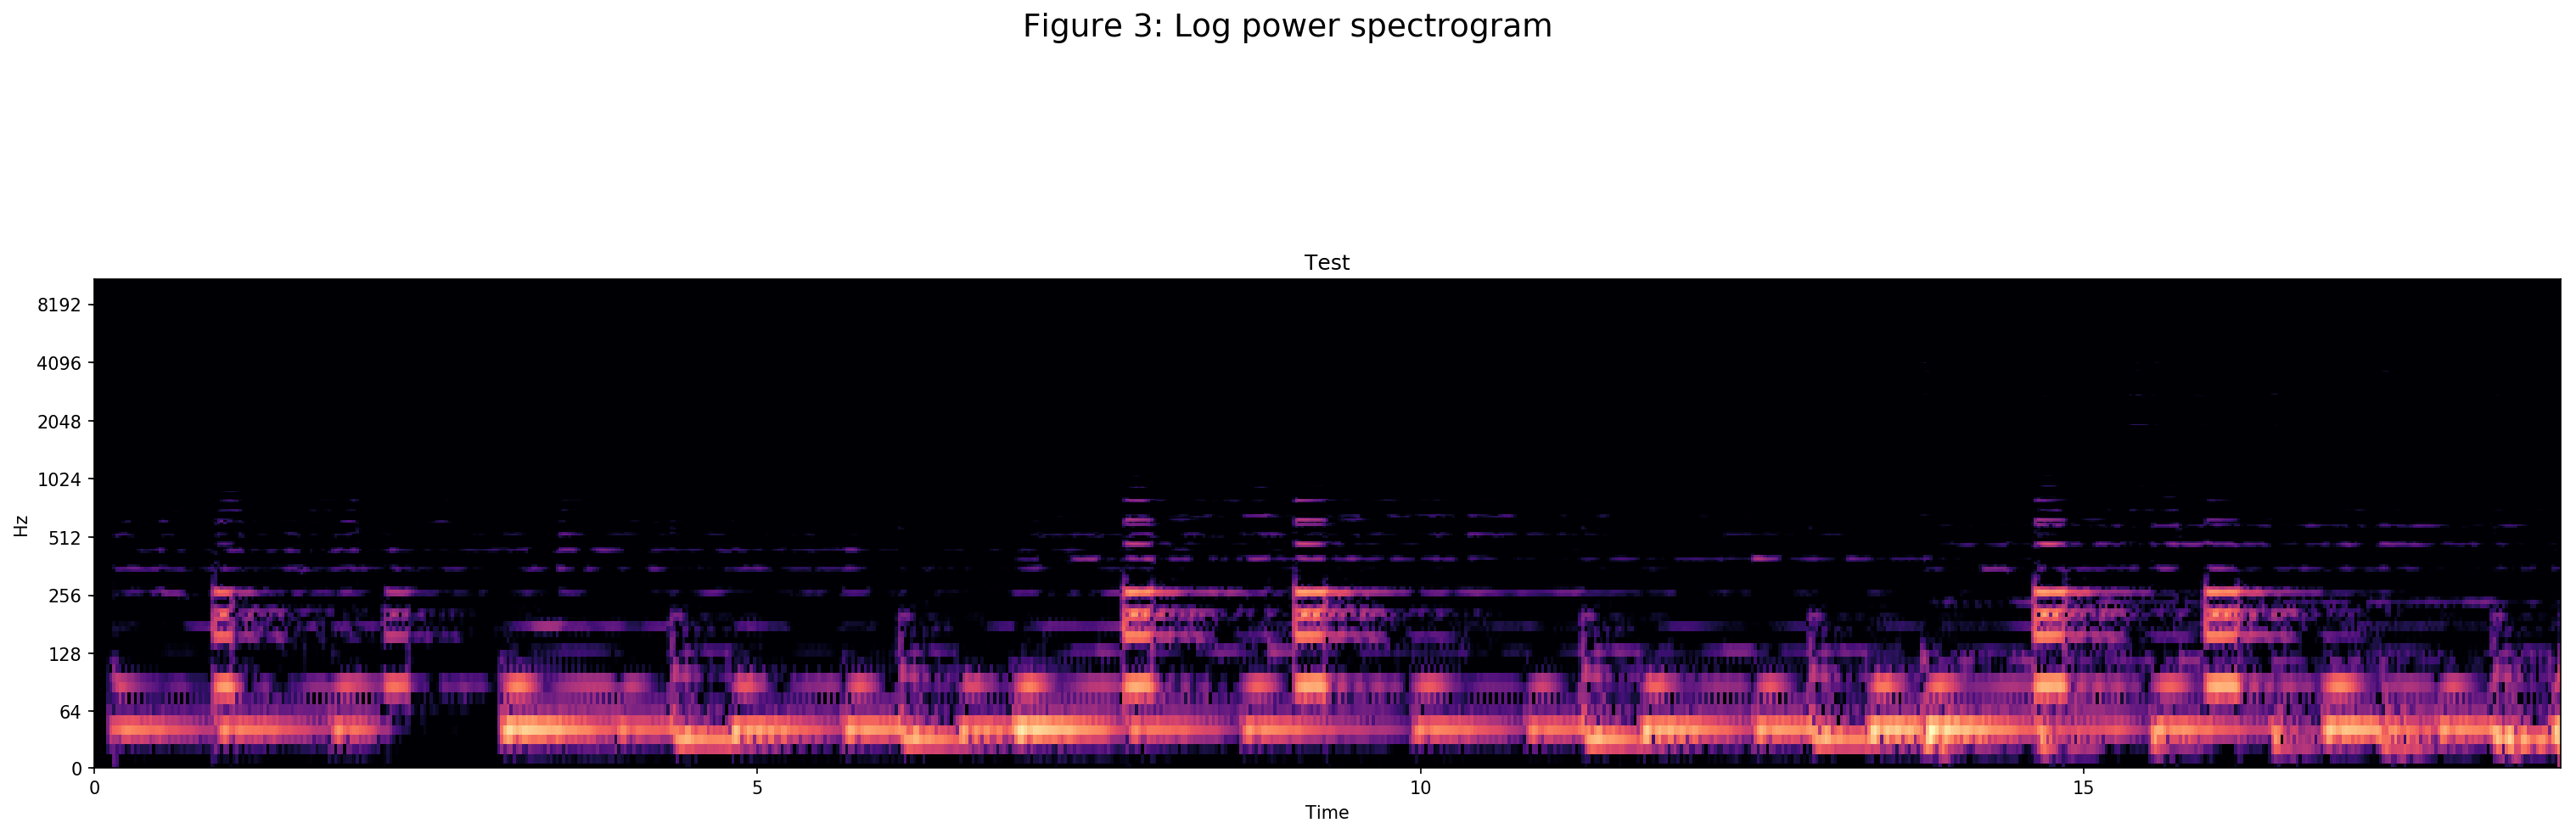

In [3]:
plot_all(sound_names = ['test'], raw_sounds = [y]) # you can plot them independently too!

# LIBRARY: pysndfx - available effects

Python wrapper for http://sox.sourceforge.net/ 

In [4]:
# !pip install pysndfx 

#  https://pypi.org/project/pysndfx/

In [5]:
from pysndfx import AudioEffectsChain

def return_global_spec(fx):
    """
    Return available effects and their parameter defaults
    Use this to generate upper, lower bounds in data generation
    """
    
    def find_defaults(sig):
        store = {}
        for param in sig.parameters.values():
            if isclass(param.default):
                store[param.name] = 'Mandatory, no default'
            else:
                store[param.name] = param.default
        return store
    
    return {k: find_defaults(signature(v)) for k,v in getmembers(fx) if \
           k.endswith('_') is False and 'command' not in k}

test_class = AudioEffectsChain()
fx_suite = return_global_spec(test_class)
del fx_suite['custom']
print ('AVAILABLE EFFECTS: {}'.format(list(fx_suite.keys())))
# pprint (fx_suite) 

AVAILABLE EFFECTS: ['bandpass', 'bandreject', 'bend', 'chorus', 'compand', 'delay', 'echo', 'equalizer', 'fade', 'flanger', 'gain', 'highpass', 'highshelf', 'limiter', 'loop', 'lowpass', 'lowshelf', 'mcompand', 'noise_reduction', 'normalize', 'oops', 'overdrive', 'phaser', 'pitch', 'reverb', 'reverse', 'sinc', 'speed', 'synth', 'tempo', 'tremolo', 'trim', 'upsample', 'vad', 'vol']


In [6]:
experimental_chain = AudioEffectsChain()
# experimental_chain

In [7]:
tt = experimental_chain.delay()

In [8]:
(tt(y).shape, y.shape)

((489380,), (410000,))

# Example: Get expected values for a single effect

In [9]:
print ("Default values for 'overdrive' are {}".format(fx_suite.get('overdrive')))

Default values for 'overdrive' are {'gain': 20, 'colour': 20}


# soundFactory 

Class mimmicing generating functionality to test single effects on tracks

In [10]:
import soundFactory

## Regression with one effect

- fxManager class will always select value at random between an upper and lower bound
- this is how we augment our data! 

In [11]:
effects = {'overdrive' : {'gain' : (0, 75)}}
effects_manager = soundFactory.fxManager(effects = effects, exercise='regression')
effects_manager.apply_effects() # call all effects, modify fx_state 
print ('What we added {}'.format(effects_manager.applied))
print ('What pysndfx added {}'.format(effects_manager.state.command))
# run sample audio

What we added {'overdrive': {'gain': 6}}
What pysndfx added ['overdrive', 6, 20]


### We asked for gain  but implicitly added colour too! Be explicit with pysndfx functionality unless it doesn't make sense for effects to be mutually exclusive. 

In [12]:
# Lets create another effects manager and ask it to omit colour using a tuple of 2 Nones
effects2 = {'overdrive' : {'gain' : (0, 75), 'colour' : (None, None)}}
effects_manager2 = soundFactory.fxManager(effects = effects2, exercise='regression')
effects_manager2.apply_effects() # call all effects, modify fx_state 
# passing (None, None) to a parameter gave it 0
print (effects_manager2.applied) # if exercise == regression we'll omit fields with zeros
print (effects_manager2.state.command ) # correct

{'overdrive': {'gain': 32, 'colour': 0}}
['overdrive', 32, 0]


# Plotting modified waveforms 

In [13]:
y_with_effects = effects_manager2.state(y) # taken from librosa plotting cell

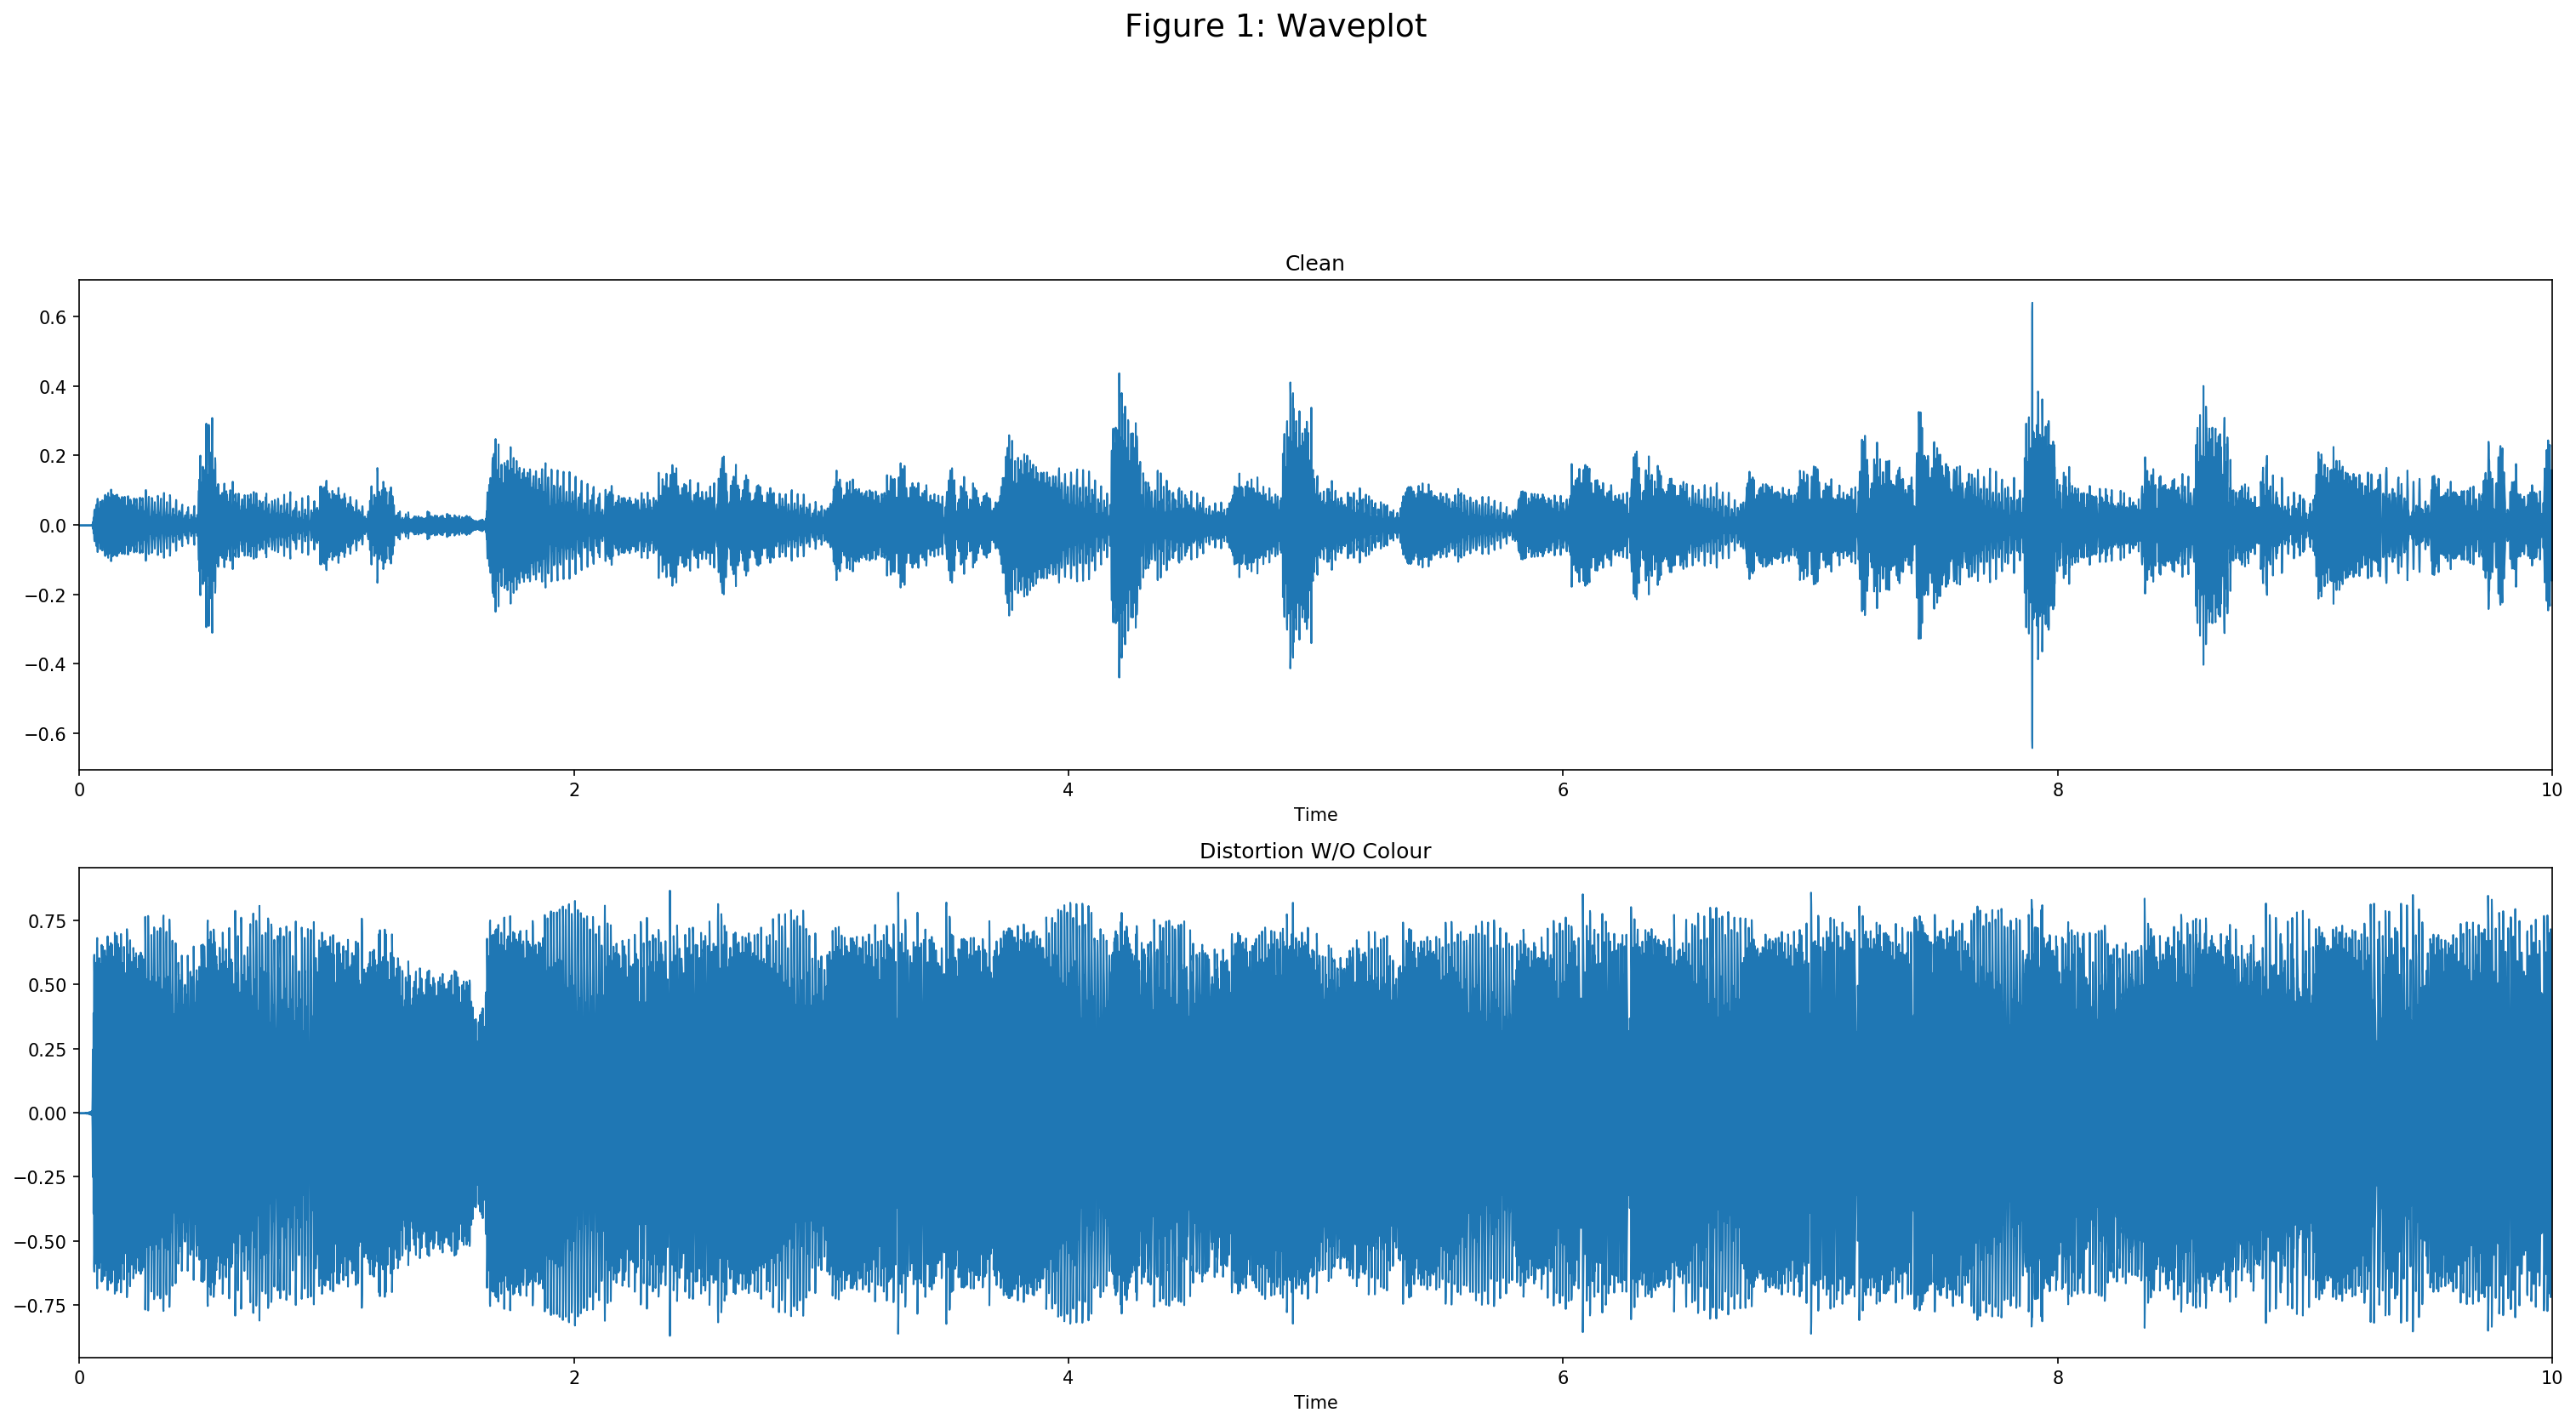

In [14]:
plot_waves(sound_names = ['clean', 'distortion w/o colour'], raw_sounds = [y,y_with_effects])

# Play these waveforms

In [15]:
import IPython.display as ipd
ipd.Audio(y_with_effects, rate=sr)

## Classification with multiple effects

- Again, random value between bounds
- This time we've requested overdrive.colour to be its default value
- For all classification tasks, fxManager will "toss coin" for whether to apply effect slated

In [16]:
# Test with 10
rows = []
for ii in range(10):
    # chooses between keeping the effect or not
    effects2 = {'overdrive' : {'gain' : (30, 75), 'colour' : 'default'}} 
    effects_manager3 = soundFactory.fxManager(effects = effects2, exercise='classification')
    effects_manager3.apply_effects()
    rows.append(effects_manager3.applied)    

# Binarize labels

In [17]:
def flatten(x, par = '', sep ='.'):
    """Flatten joining parent keys with dot"""
    store = {}
    for k,v in x.items():
        if isinstance(v,dict):
            store = {**store, **flatten(v, par =  par + sep + k if par else k)}
        else:
            store[par + sep + k] = v
    return store

label_df = pd.DataFrame(list(map(flatten, rows)))
label_df = label_df.where(label_df == 0).fillna(1)
label_df

,overdrive.colour,overdrive.gain
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,1.0
4,0.0,0.0
5,0.0,1.0
6,0.0,0.0
7,0.0,0.0
8,1.0,1.0
9,0.0,0.0


In [18]:
annotations = pd.read_csv('summary_of_annotations.csv',index_col = 0)
annotations.set_index('audioFileName', inplace = True)

In [19]:
annotations.head()

,excitationStyle,expressionStyle,fretNumber,guitarModel,instrument,offsetSec,onsetSec,pitch,recordingDate,stringNumber
audioFileName,,,,,,,,,,
G53-40100-1111-00001.wav,PK,NO,0,Fender Strat Clean Neck SC,EGUI,2.5,0.2,40,07.01.2013,1
G53-41101-1111-00002.wav,PK,NO,1,Fender Strat Clean Neck SC,EGUI,2.5,0.2,41,07.01.2013,1
G53-42102-1111-00003.wav,PK,NO,2,Fender Strat Clean Neck SC,EGUI,2.5,0.2,42,07.01.2013,1
G53-43103-1111-00004.wav,PK,NO,3,Fender Strat Clean Neck SC,EGUI,2.5,0.2,43,07.01.2013,1
G53-44104-1111-00005.wav,PK,NO,4,Fender Strat Clean Neck SC,EGUI,2.5,0.2,44,07.01.2013,1


In [20]:
(annotations['onsetSec'] - annotations['offsetSec'])

audioFileName
G53-40100-1111-00001.wav   -2.3000
G53-41101-1111-00002.wav   -2.3000
G53-42102-1111-00003.wav   -2.3000
G53-43103-1111-00004.wav   -2.3000
G53-44104-1111-00005.wav   -2.3000
G53-45105-1111-00006.wav   -2.3000
G53-45200-1111-00014.wav   -2.3000
G53-46106-1111-00007.wav   -2.3000
G53-46201-1111-00015.wav   -2.3000
G53-47107-1111-00008.wav   -2.3000
G53-47202-1111-00016.wav   -2.3000
G53-48108-1111-00009.wav   -2.3000
G53-48203-1111-00017.wav   -2.3000
G53-49109-1111-00010.wav   -2.3000
G53-49204-1111-00018.wav   -2.3000
G53-50110-1111-00011.wav   -2.3000
G53-50205-1111-00019.wav   -2.3000
G53-50300-1111-00027.wav   -2.3100
G53-51111-1111-00012.wav   -2.3000
G53-51206-1111-00020.wav   -2.3000
G53-51301-1111-00028.wav   -2.3000
G53-52112-1111-00013.wav   -2.3000
G53-52207-1111-00021.wav   -2.3000
G53-52302-1111-00029.wav   -2.3000
G53-53208-1111-00022.wav   -2.3000
G53-53303-1111-00030.wav   -2.3000
G53-54209-1111-00023.wav   -2.3000
G53-54304-1111-00031.wav   -2.3000
G53-55

# Full Augmentation

In [28]:
# Constraint on the generator mimimicking what an amateur guitarist might play with

effects_to_randomize = {'overdrive': ['gain', 'colour']}
effects_to_steady = {'overdrive': ['gain']} # where the exercise is classification
effects = {
    'overdrive' :  {'gain' : (10,80), 'colour' :  (0, 20)},
#     'reverb': {
#             'reverberance' : (0,100),
#             'hf_damping': 50,
#             'pre_delay': 20,
#             'reverberance': 50,
#             'room_scale': 100,
#             'stereo_depth': 100,
#             'wet_gain': 0,
#             'wet_only': False
#                 },
#     'delay' : 
#             {'decays': [0.3, 0.25],
#              'delays': [1000, 1800],
#              'gain_in': 0.8,
#              'gain_out': 0.5,
#              'parallel': False}
}

def load_track(path, sr = 44100):
    
    """Unlikely we make modifications to this but nice to have it separately"""
    
    x, sr = librosa.load(path, sr = sr) # default
    return x

def randomize(d, e, exercise):

    store_new = {}
    for param, value in d.items():
        if param in effects_to_randomize.get(e):     
            upper, lower = value
            rand_val = random.randint(upper, lower)
            #  chance of 0 if classification
            store_new[param] = rand_val if exercise == 'regression' else random.choice([0, rand_val])
    return store_new
    
def simple_gen(soundfile, effects, exercise):
    """
    Simple augmentation
    
    """
    fx_manager = AudioEffectsChain()
    applied = {}
    for effect, parameters in effects.items():
        if exercise != 'regression':
            if effect not in effects_to_steady:
                
                # if want to turn all other features on / off 
                # check if its not required to be constant
                
                if int(random.choice([True, False])) == 0:
                    #  pass on effect completely
                    continue 
        fx = getattr(fx_manager, effect)
        if effect in effects_to_randomize:
            parameters = randomize(parameters, e = effect, exercise = exercise)
        fx(**parameters)
        applied[effect] = parameters
    augmented = fx_manager(soundfile)
    return (augmented, applied)

def normalize_arrays(inputs):
    
    # get largest shape
    inputs = np.atleast_2d(*inputs)
    max_shape = max([i.shape for i in inputs], key = lambda x: x[len(inputs[0] - 1)])

    def padder(inp, max_shape): 
        # Normalize shapes for concat
        zero_grid = np.zeros(max_shape)
        x,y = inp.shape
        zero_grid[:x, :y] = inp
        return zero_grid

    return [padder(ii, max_shape) for ii in inputs]

def make_tabular(samples):
    """
    Return tracks (NDarray) and features (DataFrame) in tabular form  
    """

    X, features = zip(*samples)
    X = normalize_arrays(X)
    stacked = np.stack(X)
    # Using dot notation for column names after unnesting records
    unnest = lambda x: flatten(x)
    effects_added = pd.DataFrame(list(map(unnest, features)))
    return (stacked, effects_added)

def sound_factory(soundfiles, batch_size, augment_n, effects, exercise, path = None):

    """
    Augment tracks in bulk, will transform later to keras type generator

    """

    while True:

        # take n samples from series object passed
        soundfiles =  [path + x for x in soundfiles]
        batch_files = random.sample(soundfiles, k = batch_size)

        batch_inputs = []
        batch_outputs = []

        for soundfile in batch_files:    
            
            sf = soundfile.split('/')[-1]
            meta = annotations.loc[sf].to_dict() # dealing with onset?
            meta = flatten({'meta' : meta})

            # Load once
            track = load_track(soundfile)

            augmented = [simple_gen(track, 
                                   effects,
                                    exercise
                                   ) for i in range(augment_n)]
        
            
            features, labels = make_tabular(augmented)
            
            for field, annotation in meta.items():
                labels[field] = annotation

            if exercise == 'classification':
                # binarize each column
                labels = labels.where(labels == 0).fillna(1)

            batch_inputs.append(features)
            batch_outputs.append(labels)
        
        max_shape = max([x.shape for x in batch_inputs], key = lambda x: x[2])
        
        def padder(inp, max_shape): 
            # Normalize shapes for concat
            zero_grid = np.zeros(max_shape)
            x,y,z= inp.shape
            zero_grid[:x, :y, :z] = inp
            return zero_grid
        
        normalized_batch_inputs = [padder(x, max_shape) for x in batch_inputs]

        # not sure if I have to keep stacking
        batch_x = np.vstack(normalized_batch_inputs)
        # how do we represent outputs?
        batch_y = pd.concat(batch_outputs, axis = 0).reset_index()

        yield (batch_x, batch_y)


## Generating data

In [29]:
fx_suite.get('overdrive') # check parameters

{'colour': 20, 'gain': 20}

In [30]:
# We already have a standard file split! 
data = json.load(fp = open('official_data_split.json', 'r'))
print ('Filesets available {}'.format(list(data.keys())))

pipeline_settings = {
    'effects' : effects,
    'exercise' : 'regression',
    'batch_size': 10, # number of audio tracks taken
    'augment_n' : 20 # number of augmentations per track
}
print ('Anticipated number of examples : {}'.format(
    pipeline_settings.get('batch_size') * pipeline_settings.get('augment_n')))

# Instantiating generator
train_generator = sound_factory(path = DOWNLOAD_PATH, soundfiles = data.get('train'), **pipeline_settings)
# generating, call once - not a keras type generator yet
train_X, train_Y = next(train_generator) 


Filesets available ['train', 'test']
Anticipated number of examples : 200


In [31]:
train_X.shape #

(200, 1, 110250)

In [32]:
np.save('t_x', train_X)

In [33]:
train_Y # numpy record type

,index,overdrive.colour,overdrive.gain,meta.excitationStyle,meta.expressionStyle,meta.fretNumber,meta.guitarModel,meta.instrument,meta.offsetSec,meta.onsetSec,meta.pitch,meta.recordingDate,meta.stringNumber
0,0,3,54,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
1,1,19,64,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
2,2,5,51,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
3,3,10,65,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
4,4,19,61,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
5,5,17,73,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
6,6,11,76,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
7,7,12,45,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
8,8,18,12,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5
9,9,18,59,PK,NO,10,Ibanez Power Strat Clean Neck HU,EGUI,2.5000,0.207,69,07.01.2013,5


In [34]:
train_Y.to_csv(open('t_y.csv', 'w'))

# Further w/ guidance on training

> Tristan's Keras implementation of sincnet - https://github.com/mravanelli/SincNet
>> https://github.com/AI-Guru/SincNet

> Kapre Library provides trainable layers in lieu of preprocessed feature engineering 
>> https://github.com/keunwoochoi/kapre/blob/master/examples/example_codes.ipynb
    
> Jake G's urban sound classification - I stole his plotting functions
>> https://github.com/jake-g/urban-sound-classification/blob/github/utils.py
 
>Another attempt, this one with acompanying blog - feature engineer is interesting in this and the aforementioned
>> https://github.com/aqibsaeed/Urban-Sound-Classification
